In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/magnesium/Documents/Light House Labs Bootcamp/Projects/Final Project/data/combined_data_2015_2022_pivoted_filtered 2.csv')

In [3]:
import folium

# Create a DataFrame with unique locations and their latitude/longitude
unique_locations = df[['location', 'latitude', 'longitude']].drop_duplicates()

# Create a map centered around the average latitude and longitude of your locations
avg_latitude = unique_locations['latitude'].mean()
avg_longitude = unique_locations['longitude'].mean()
my_map = folium.Map(location=[avg_latitude, avg_longitude], zoom_start=5)

# Add a marker for each unique location
for index, row in unique_locations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['location'],
        icon=None,
    ).add_to(my_map)

# Show the map
my_map

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

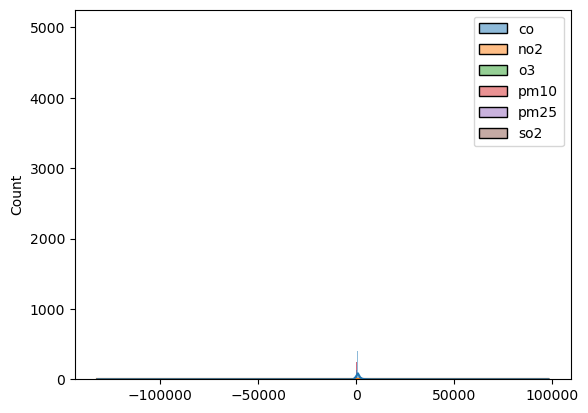

In [5]:
df_sample = df.sample(frac=0.1)  # This takes a random 10% sample of the data
sns.histplot(df_sample[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']], kde=True)
plt.show()

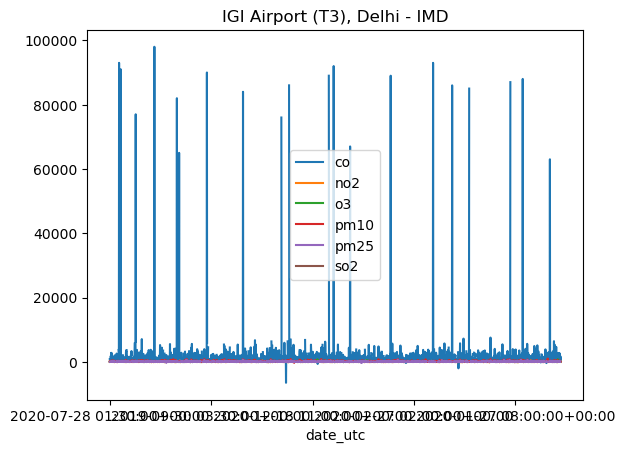

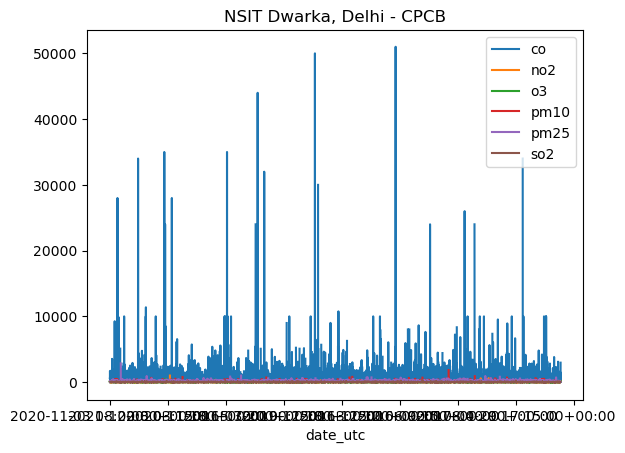

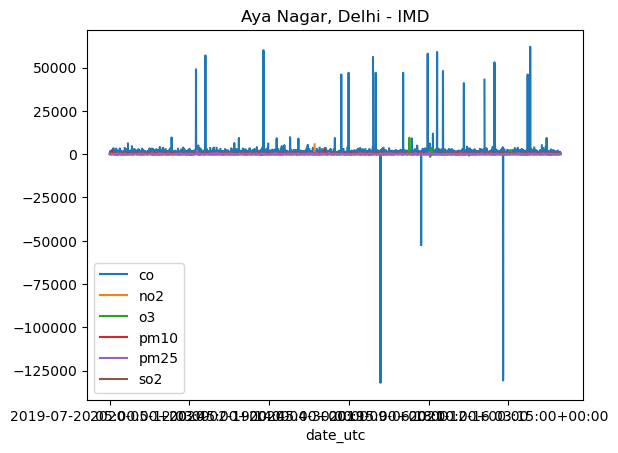

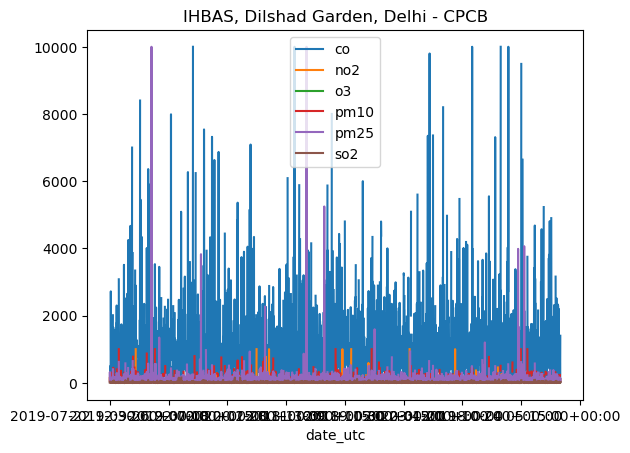

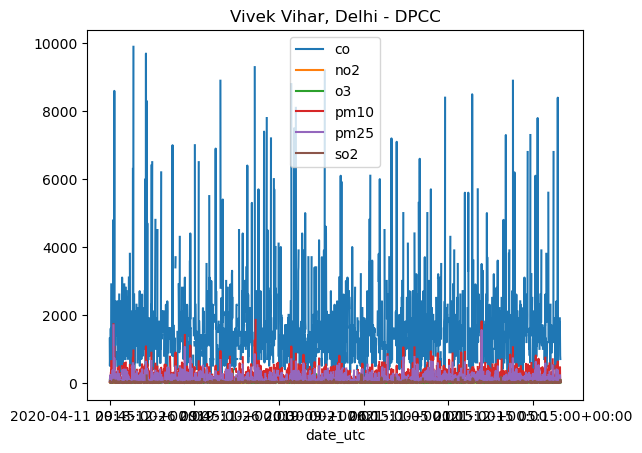

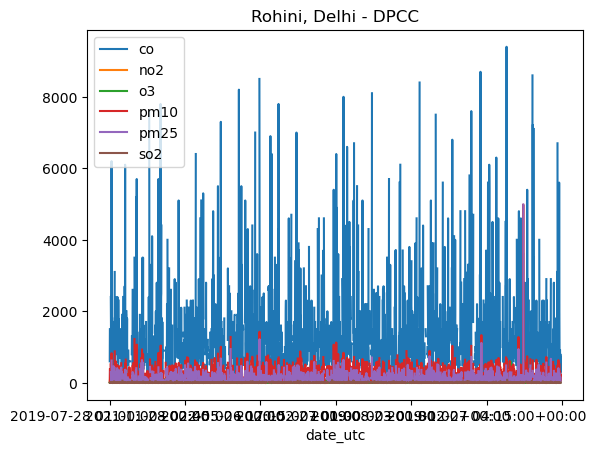

In [6]:
for location in df_sample['location'].unique():
    location_data = df_sample[df_sample['location'] == location]
    location_data.set_index('date_utc')[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']].plot()
    plt.title(location)
    plt.show()

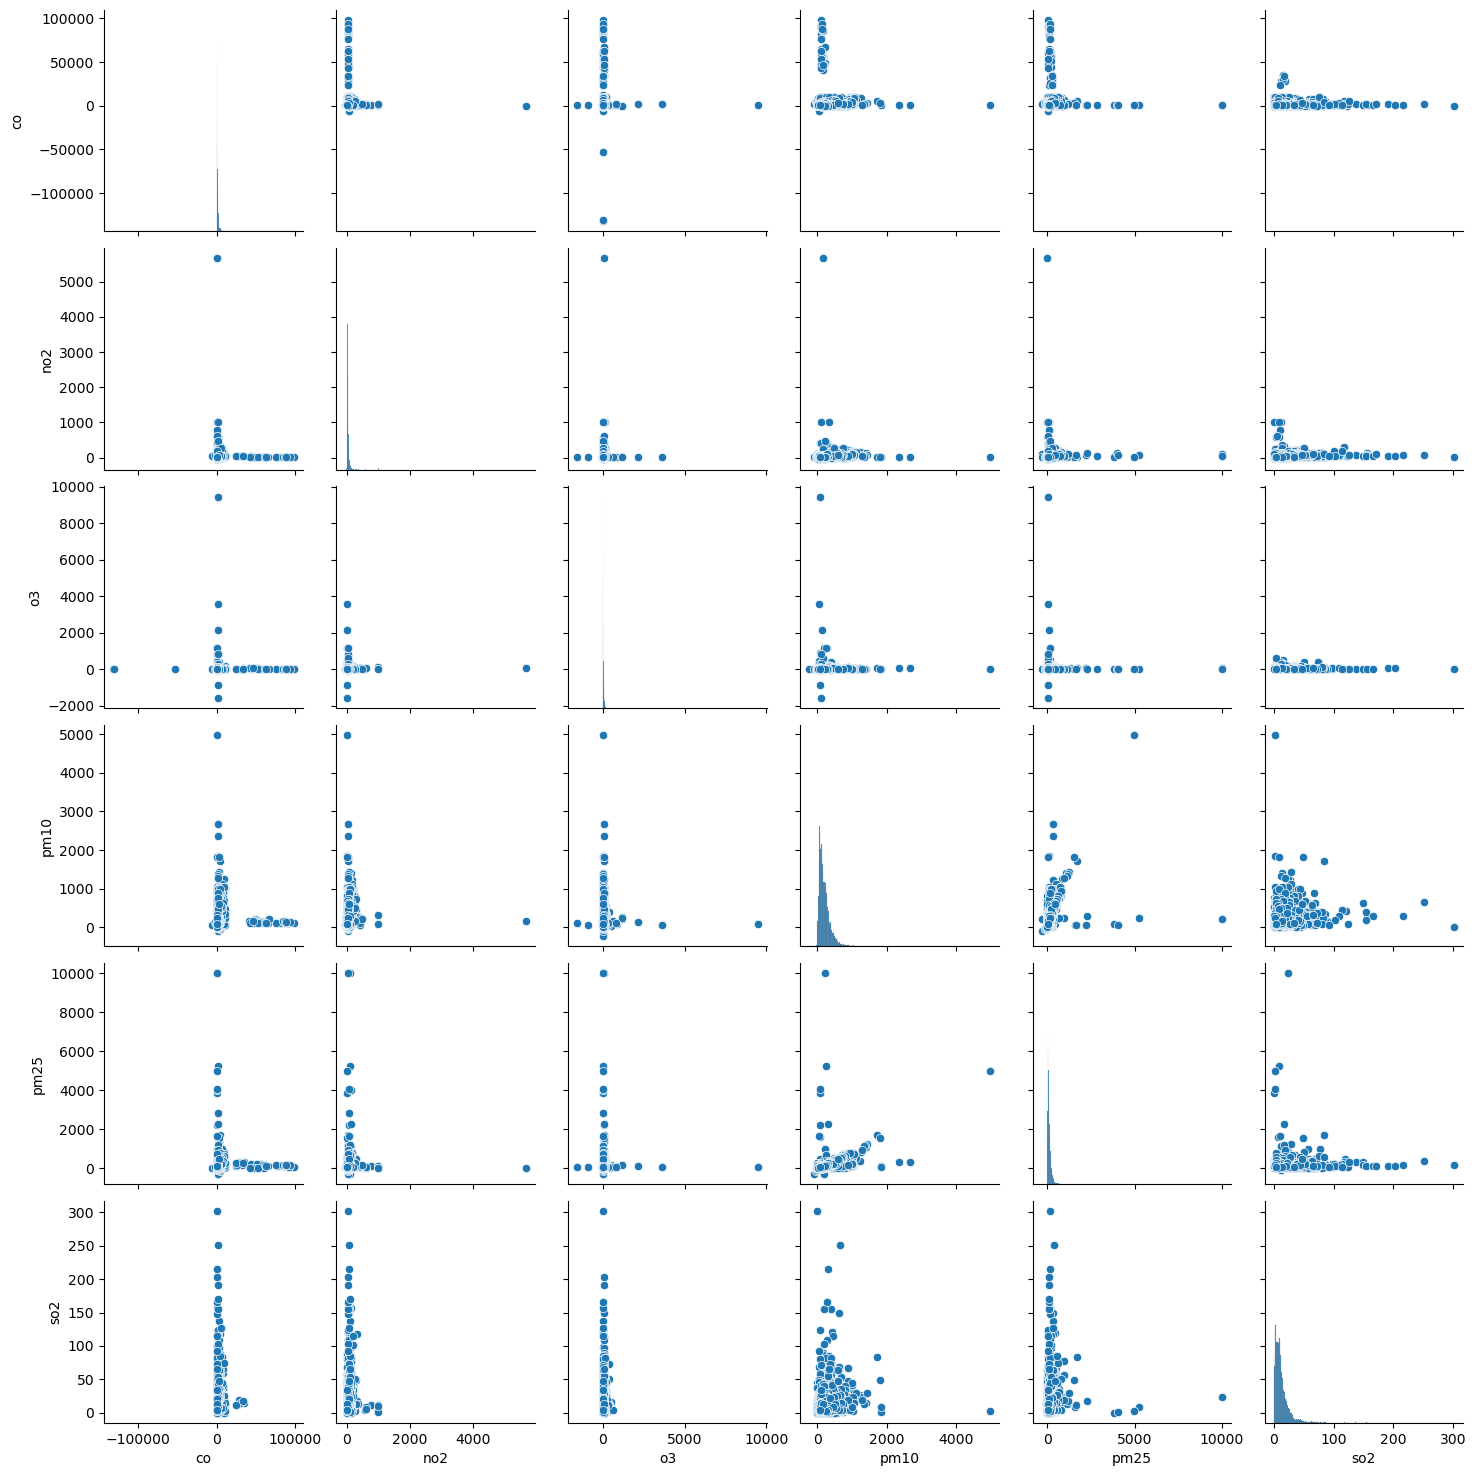

In [7]:
# c. Examine the correlation between different pollutants
sns.pairplot(df_sample[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']])
plt.show()

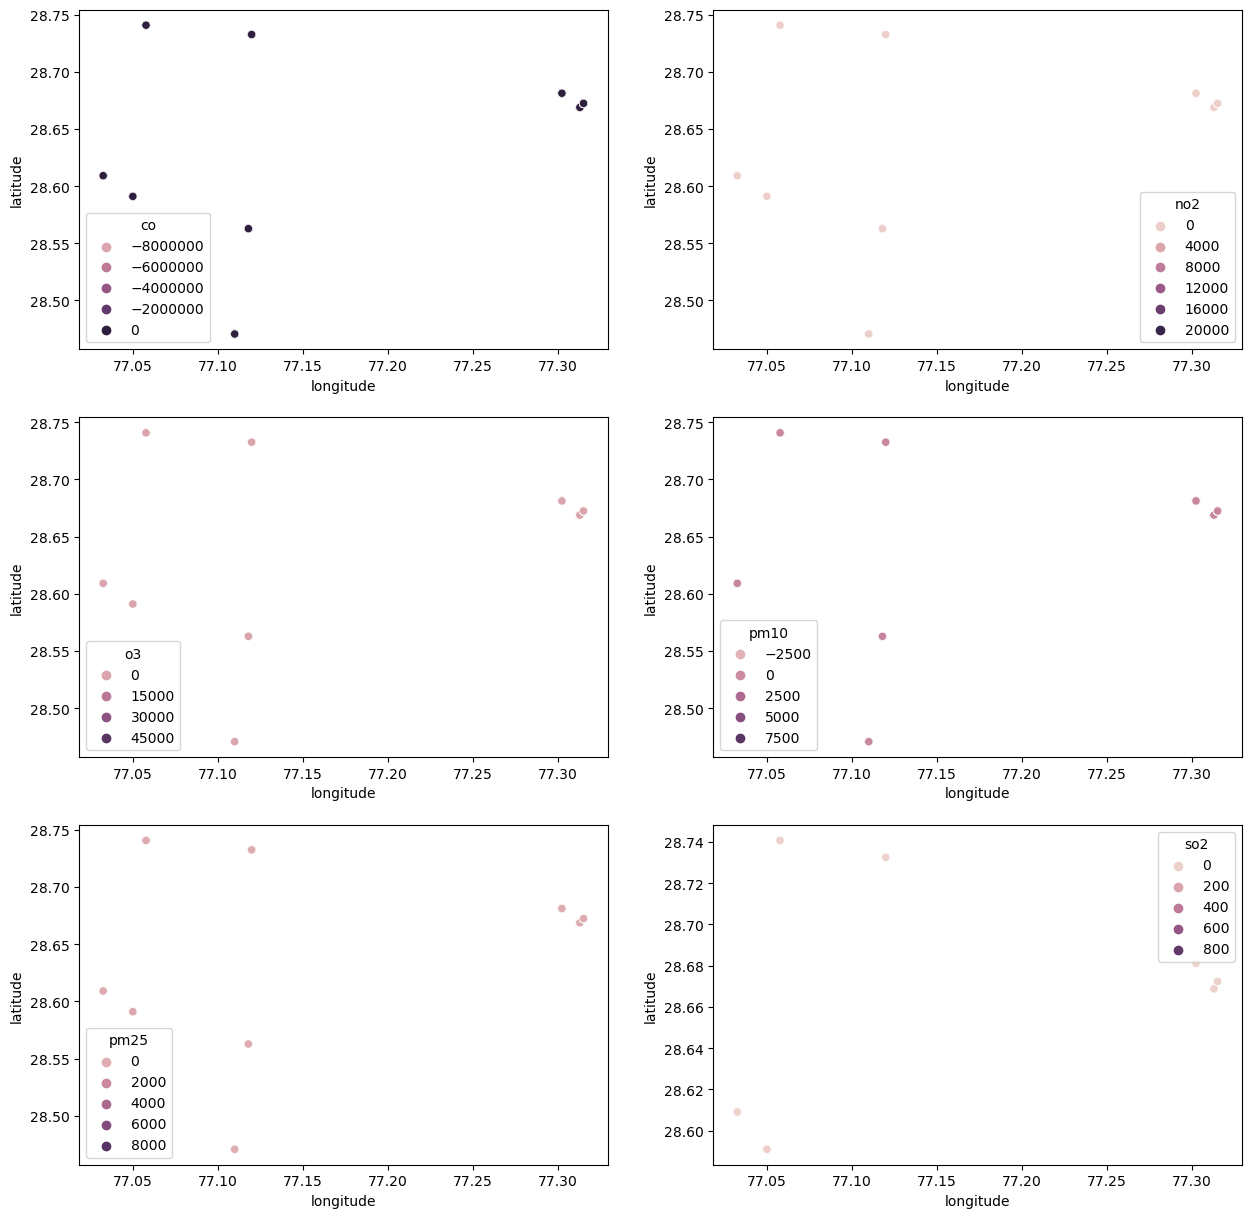

In [8]:
# d. Create scatter plots to visualize the spatial distribution of pollutant concentrations
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']
for i, ax in enumerate(axes.flat):
    sns.scatterplot(data=df, x='longitude', y='latitude', hue=pollutants[i], ax=ax)
plt.show()

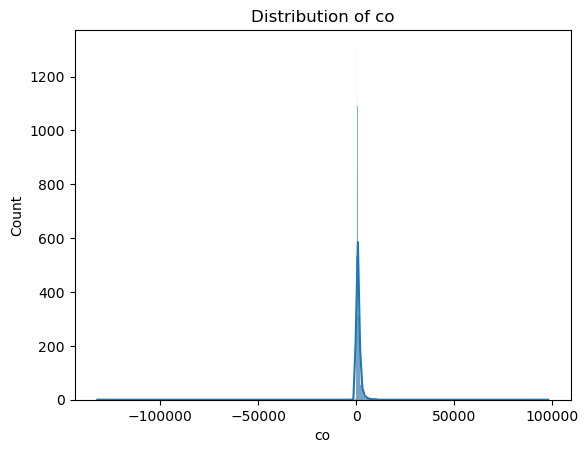

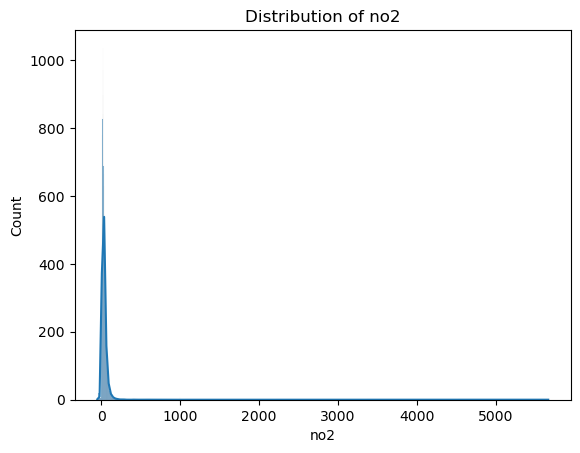

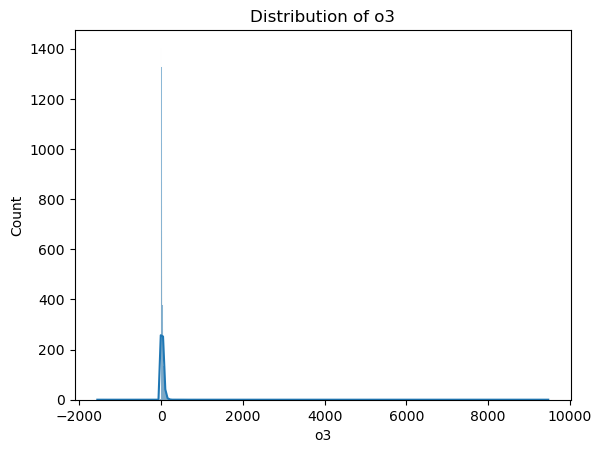

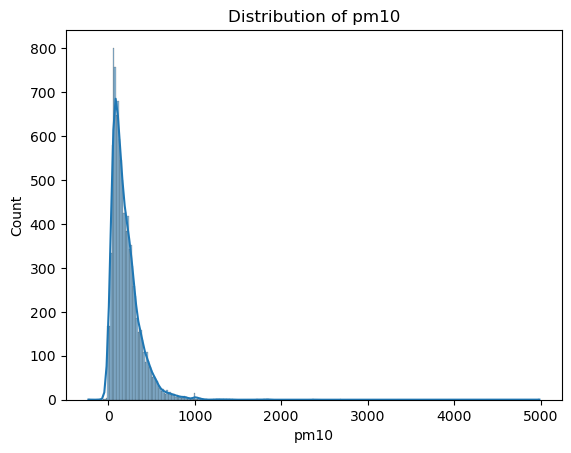

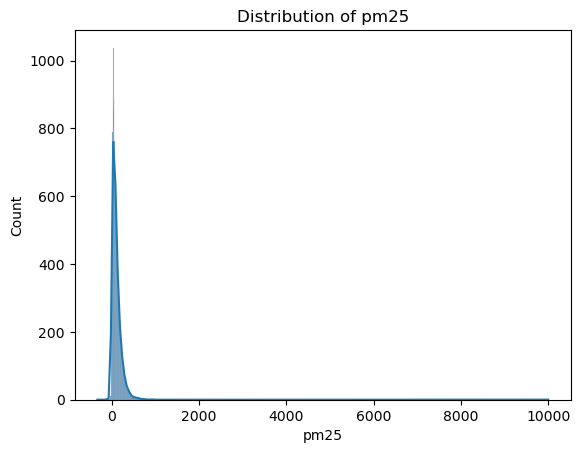

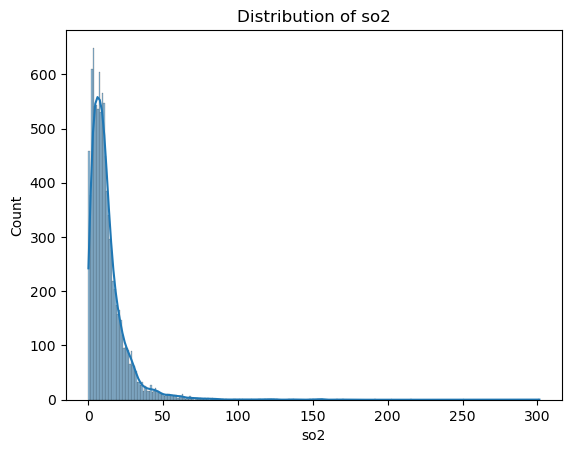

In [9]:
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

for pollutant in pollutants:
    sns.histplot(df_sample[pollutant], kde=True)
    plt.title(f'Distribution of {pollutant}')
    plt.show()

In [10]:
# a. Plot the distribution of pollutants
#sns.histplot(df[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']], kde=True)
#plt.show()

In [11]:
# b. Visualize the time series for each pollutant and location
#for location in df['location'].unique():
    #location_data = df[df['location'] == location]
    #location_data.set_index('date_utc')[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']].plot()
    #plt.title(location)
    #plt.show()

In [12]:
# c. Examine the correlation between different pollutants
#sns.pairplot(df[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']])
#plt.show()

In [13]:
# d. Create scatter plots to visualize the spatial distribution of pollutant concentrations
#fig, axes = plt.subplots(3, 2, figsize=(15, 15))
#pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']
#for i, ax in enumerate(axes.flat):
    #sns.scatterplot(data=df, x='longitude', y='latitude', hue=pollutants[i], ax=ax)
#plt.show()

# e. Identify potential outliers and investigate their potential causes
# This step depends on the specific domain knowledge and data

In [14]:
# Convert 'date_utc' to datetime and sort the dataframe
df['date_utc'] = pd.to_datetime(df['date_utc'])
df.sort_values(['location', 'date_utc'], inplace=True)

# Set 'date_utc' as index
df.set_index('date_utc', inplace=True)

# Interpolate missing values using the time method
df.interpolate(method='time', inplace=True)

# Reset the index to have 'date_utc' as a column again
df.reset_index(inplace=True)

In [ ]:
# Export the cleaned data to a new csv file before imputing missing values
df.to_csv('/Users/magnesium/Documents/Light House Labs Bootcamp/Projects/Final Project/data/combined_data_2015_2022_pivoted_filtered_not_imputed.csv', index=False)


In [15]:
# Set k for KNN imputation
k = 5

# Prepare the dataset
df_for_imputation = df[['latitude', 'longitude', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]

# Perform KNN imputation
imputer = KNNImputer(n_neighbors=k)
imputed_data = imputer.fit_transform(df_for_imputation)

# Replace the original data with the imputed data
df[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']] = imputed_data[:, 2:]

In [16]:
# Step 4 (repeated): Spatial imputation

# Group by location and apply the interpolate method
grouped = df.groupby('location')
df_imputed = []

for name, group in grouped:
    group.set_index('date_utc', inplace=True)
    group.interpolate(method='time', inplace=True)
    df_imputed.append(group)

# Combine the imputed data back into a single dataframe
df = pd.concat(df_imputed)
df.reset_index(inplace=True)

# Step 5 (repeated): Time-based imputation

# Convert 'date_utc' to datetime and sort the dataframe
df['date_utc'] = pd.to_datetime(df['date_utc'])
df.sort_values(['location', 'date_utc'], inplace=True)

# Set 'date_utc' as index
df.set_index('date_utc', inplace=True)

# Interpolate missing values using the time method
df.interpolate(method='time', inplace=True)

# Reset the index to have 'date_utc' as a column again
df.reset_index(inplace=True)

In [17]:
# export new dataframe to csv
df.to_csv('/Users/magnesium/Documents/Light House Labs Bootcamp/Projects/Final Project/data/air_quality_imputed.csv', index=False)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 7. Train and evaluate machine learning models
# a. Split the data into training and testing sets
X = df.drop(['date_utc', 'location', 'latitude', 'longitude', 'pm25'], axis=1)
y = df['pm25']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# b. Train models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# c. Make predictions
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# d. Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'{model_name} Evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    print('-------------------------')

evaluate_model(y_test, lr_pred, 'Linear Regression')
evaluate_model(y_test, rf_pred, 'Random Forest')


Linear Regression Evaluation:
Mean Squared Error: 31891.451435016654
Mean Absolute Error: 56.95833487492746
R^2 Score: 0.09284114414019262
-------------------------
Random Forest Evaluation:
Mean Squared Error: 19813.7225053477
Mean Absolute Error: 32.54068005735633
R^2 Score: 0.43639461267857627
-------------------------


In [19]:
df.shape

(223206, 10)

In [20]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print("-------------------------")

In [21]:
# Sample a smaller subset of the data
sample_size = 10000  # Adjust this value according to your preference
df_sample = df.sample(sample_size, random_state=42)

# Split the sample data into training and testing sets
X_sample = df_sample.drop(['date_utc', 'location', 'latitude', 'longitude', 'pm25'], axis=1)
y_sample = df_sample['pm25']

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train and evaluate the models on the smaller dataset
# Gradient Boosting
gb_model_sample = GradientBoostingRegressor(random_state=42)
gb_model_sample.fit(X_train_sample, y_train_sample)
evaluate_model(gb_model_sample, X_test_sample, y_test_sample, "Gradient Boosting")

# XGBoost
xgb_model_sample = xgb.XGBRegressor(random_state=42)
xgb_model_sample.fit(X_train_sample, y_train_sample)
evaluate_model(xgb_model_sample, X_test_sample, y_test_sample, "XGBoost")

# LightGBM
lgb_model_sample = lgb.LGBMRegressor(random_state=42)
lgb_model_sample.fit(X_train_sample, y_train_sample)
evaluate_model(lgb_model_sample, X_test_sample, y_test_sample, "LightGBM")

Gradient Boosting Evaluation:
Mean Squared Error: 68829.25058585337
Mean Absolute Error: 53.344119509372916
R^2 Score: 0.059144414107342835
-------------------------
XGBoost Evaluation:
Mean Squared Error: 69391.96702236502
Mean Absolute Error: 51.0674222449402
R^2 Score: 0.051452409646169595
-------------------------
LightGBM Evaluation:
Mean Squared Error: 69726.11480509845
Mean Absolute Error: 52.38149263565293
R^2 Score: 0.04688480495452407
-------------------------


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Gradient Boosting
gb_pred = gb_model_sample.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print("Gradient Boosting Evaluation:")
print(f"Mean Squared Error: {gb_mse}")
print(f"Mean Absolute Error: {gb_mae}")
print(f"R^2 Score: {gb_r2}")
print("-------------------------")

# XGBoost
xgb_pred = xgb_model_sample.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost Evaluation:")
print(f"Mean Squared Error: {xgb_mse}")
print(f"Mean Absolute Error: {xgb_mae}")
print(f"R^2 Score: {xgb_r2}")
print("-------------------------")

# LightGBM
lgb_pred = lgb_model_sample.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_pred)
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print("LightGBM Evaluation:")
print(f"Mean Squared Error: {lgb_mse}")
print(f"Mean Absolute Error: {lgb_mae}")
print(f"R^2 Score: {lgb_r2}")
print("-------------------------")

Gradient Boosting Evaluation:
Mean Squared Error: 29877.92770180374
Mean Absolute Error: 50.220966466195634
R^2 Score: 0.1501162383700656
-------------------------
